In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, fcluster

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jobs-dataset-from-glassdoor/salary_data_cleaned.csv
/kaggle/input/jobs-dataset-from-glassdoor/glassdoor_jobs.csv
/kaggle/input/jobs-dataset-from-glassdoor/eda_data.csv


In [31]:
df = pd.read_csv("/kaggle/input/jobs-dataset-from-glassdoor/salary_data_cleaned.csv")
df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\n,FL,1,10,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\n,WA,1,55,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,Company - Public,...,84.5,GSK\n,MA,0,190,0,0,0,1,0
738,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,...,102.5,Eventbrite\n,TN,0,14,1,0,1,1,0
739,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,...,73.5,Software Engineering Institute\n,PA,1,36,0,0,0,0,1
740,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,...,127.5,"Numeric, LLC\n",PA,0,-1,0,0,0,0,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          742 non-null    object 
 1   Salary Estimate    742 non-null    object 
 2   Job Description    742 non-null    object 
 3   Rating             742 non-null    float64
 4   Company Name       742 non-null    object 
 5   Location           742 non-null    object 
 6   Headquarters       742 non-null    object 
 7   Size               742 non-null    object 
 8   Founded            742 non-null    int64  
 9   Type of ownership  742 non-null    object 
 10  Industry           742 non-null    object 
 11  Sector             742 non-null    object 
 12  Revenue            742 non-null    object 
 13  Competitors        742 non-null    object 
 14  hourly             742 non-null    int64  
 15  employer_provided  742 non-null    int64  
 16  min_salary         742 non

In [33]:
data = df[["avg_salary", "Rating"]]
data.head(20)

,avg_salary,Rating
0,72.0,3.8
1,87.5,3.4
2,85.0,4.8
3,76.5,3.8
4,114.5,2.9
5,95.0,3.4
6,73.5,4.1
7,114.0,3.8
8,61.0,3.3
9,140.0,4.6


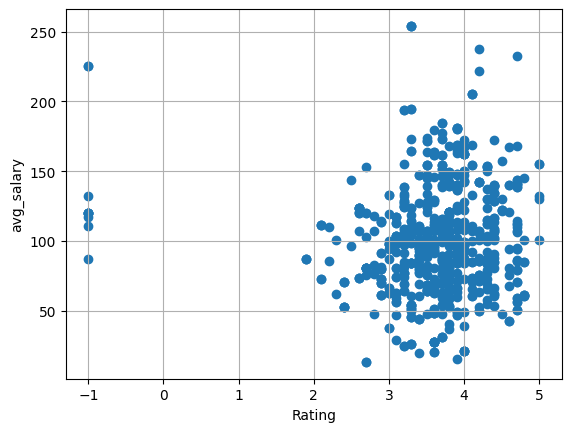

In [34]:
plt.scatter(df["Rating"],df["avg_salary"])
plt.xlabel("Rating")
plt.ylabel("avg_salary")
plt.grid(True)
plt.show()

# ***Implementing Partitioning Clustering***

In [36]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["avg_salary", "Rating"]])

In [58]:
from sklearn.cluster import KMeans
num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(df_scaled)

df['cluster_pred'] = kmeans.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [59]:
centroids = kmeans.cluster_centers_

centroids_original = scaler.inverse_transform(centroids)
centroid_ratings = centroids_original[:, 1]
df['predicted_rating'] = df['cluster_pred'].map(dict(zip(range(num_clusters), centroid_ratings)))

In [60]:
Partitioning_output = df[['avg_salary', 'Rating', 'predicted_rating', 'cluster_pred']].head()
Partitioning_output.head()

,avg_salary,Rating,predicted_rating,cluster_pred
0,72.0,3.8,3.525175,0
1,87.5,3.4,3.085787,2
2,85.0,4.8,4.107595,4
3,76.5,3.8,4.107595,4
4,114.5,2.9,3.085787,2


In [61]:
mse = mean_squared_error(df['Rating'], df['predicted_rating'])
r2 = r2_score(df['Rating'], df['predicted_rating'])

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.1460635083603974
R-squared: 0.7721576081309142


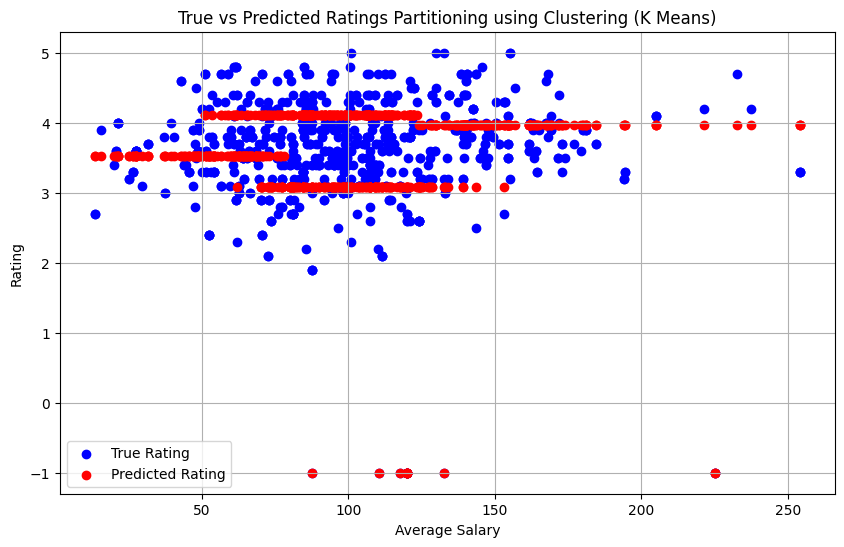

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_salary'], df['Rating'], color='blue', label='True Rating')
plt.scatter(df['avg_salary'], df['predicted_rating'], color='red', label='Predicted Rating')
plt.xlabel('Average Salary')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.title('True vs Predicted Ratings Partitioning using Clustering (K Means)')
plt.show()

# ***Implementing Hierarchical Clustering***

In [64]:
Z = linkage(df_scaled, method='ward')
num_clusters = 5 

cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
df['cluster_pred'] = cluster_labels - 1

In [65]:
centroids = np.array([df_scaled[cluster_labels == i].mean(axis=0) for i in range(1, num_clusters + 1)])
centroids_original = scaler.inverse_transform(centroids)

centroid_ratings = centroids_original[:, 1]
df['predicted_rating'] = df['cluster_pred'].map(dict(zip(range(num_clusters), centroid_ratings)))

In [66]:
Hierarchical_output = df[['avg_salary', 'Rating', 'predicted_rating', 'cluster_pred']].head()
Hierarchical_output.head()

,avg_salary,Rating,predicted_rating,cluster_pred
0,72.0,3.8,4.108297,4
1,87.5,3.4,3.234082,2
2,85.0,4.8,4.108297,4
3,76.5,3.8,4.108297,4
4,114.5,2.9,3.234082,2


In [68]:
mse = mean_squared_error(df['Rating'], df['predicted_rating'])
r2 = r2_score(df['Rating'], df['predicted_rating'])

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.16343566943129076
R-squared: 0.7450590208468055


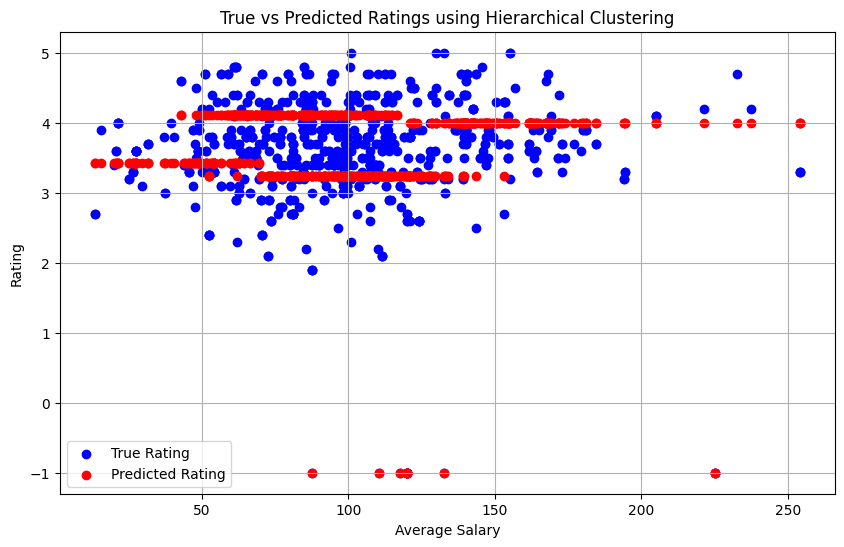

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_salary'], df['Rating'], color='blue', label='True Rating')
plt.scatter(df['avg_salary'], df['predicted_rating'], color='red', label='Predicted Rating')
plt.xlabel('Average Salary')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.title('True vs Predicted Ratings using Hierarchical Clustering')
plt.show()